In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [2]:
import pandas as pd
df = pd.read_csv("../input/question-pairs-dataset/questions.csv",nrows=100000)

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape[0]

100000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

0    62739
1    37261
Name: is_duplicate, dtype: int64

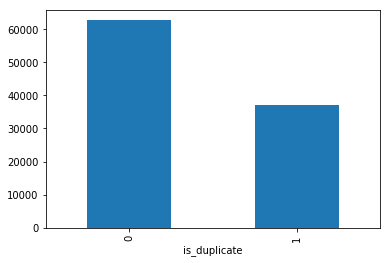

In [6]:
d=df.groupby('is_duplicate')['id'].count().plot.bar()
d=df['is_duplicate'].value_counts()
d

In [7]:
print("Percentage of duplicate question {}%".format(round(df['is_duplicate'].mean()*100,2)))
print("Percentage of non-duplicates questions {}%".format(100-round(df['is_duplicate'].mean()*100,2)))

Percentage of duplicate question 37.26%
Percentage of non-duplicates questions 62.74%


<h3>Number of Unique of questions<h3/>

In [8]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_qs=len(np.unique(qids))
qs_morethanone=np.sum(qids.value_counts()>1)

print("Unique questions {}\n".format(unique_qs))
print("Question more than one {}\n".format(qs_morethanone))
print("max value of repition {}\n".format(max(qids.value_counts())))

q_vals=qids.value_counts()

q_vals=q_vals.values

Unique questions 198436

Question more than one 1319

max value of repition 14



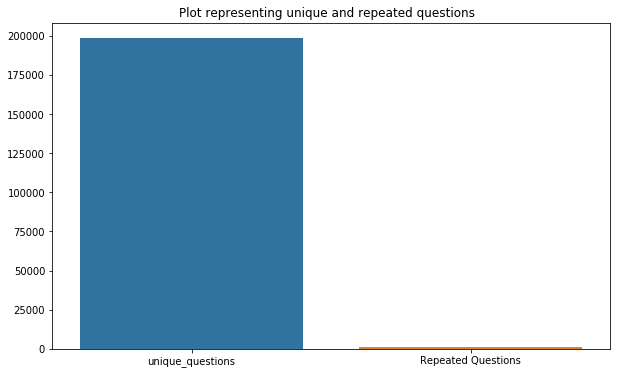

In [9]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethanone]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
pair_duplicates=df[['id','qid1','qid2']].groupby(['qid1','qid2']).count().reset_index()
num=pair_duplicates.shape[0]-df.shape[0]
pair_duplicates.shape[0]

100000

<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 14



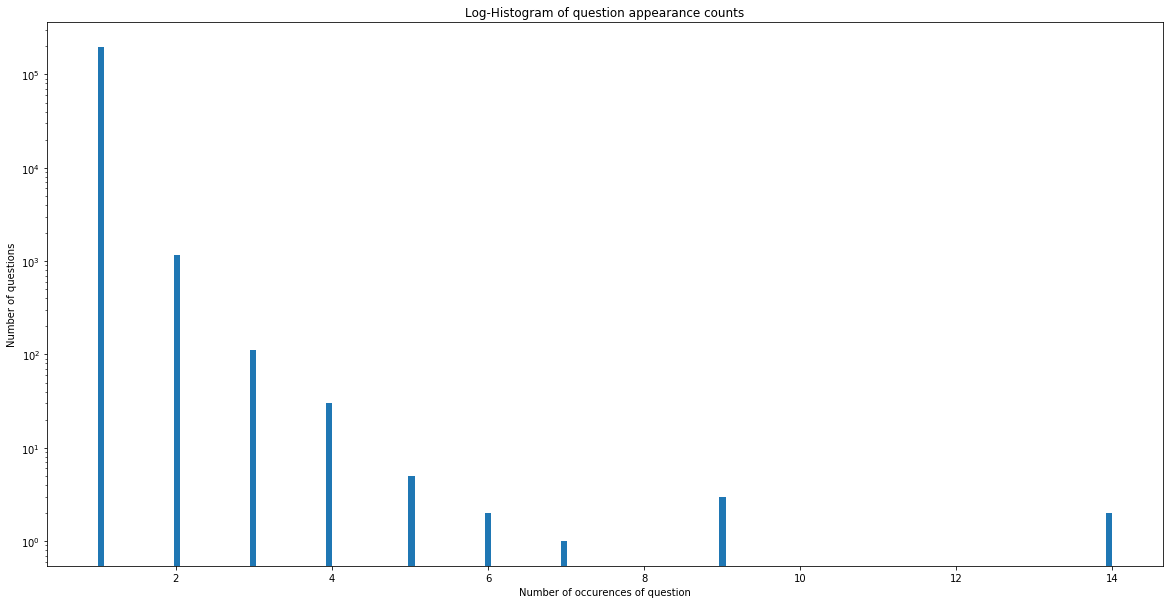

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [12]:
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [13]:
df=df.fillna('')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train1.csv'):
    df=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words']=df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words']=df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_common(row):
        w1=set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0*len(w1 & w2)
    df['word_Common']=df.apply(normalized_word_common,axis=1)
    
    def normalized_word_common(row):
        w1=set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0*(len(w1)+len(w2))
    df['word_total']=df.apply(normalized_word_common,axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    df.to_csv('df_fe_without_preprocessing_train.csv',index=False)
df.head()
    

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0
